### **Pairs Trading Strategies Using Python Part 2**


In this Jupyter notebook, we will explore and implement a pairs trading strategy using Python. 

Pairs trading is a popular mean-reversion strategy that involves trading two correlated securities, taking advantage of their historical price relationship. The strategy is particularly appealing as it is market-neutral, which means it is hedged against overall market movements.

We'll cover the following topics in this notebook:

- Stationarity, Integration, and Cointegration Concepts
- Testing for Stationarity using Augmented Dickey Fuller (ADF) Test
- Finding Cointegrated Pairs of Securities
- Creating and Backtesting the Pairs Trading Strategy

Let's get started by importing the necessary libraries:

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
yf.pdr_override()

**Stationarity, Integration, and Cointegration**

In pairs trading, we assume that the securities involved have some underlying economic link. To start, we need to understand the concepts of stationarity, integration, and cointegration.

- Stationarity: A time series is said to be stationary when its statistical properties, such as mean and variance, do not change over time.

- Integration: Integration refers to the number of differences required to make a non-stationary time series stationary. For example, first-order differencing can be used to make a non-stationary time series stationary.

- Cointegration: Two time series are said to be cointegrated if they have a long-run equilibrium relationship. In other words, their linear combination is stationary even if the individual time series are not.

**Testing for Stationarity**

We'll start by generating two time series, one stationary and another non-stationary, and plot them to visualize the difference:

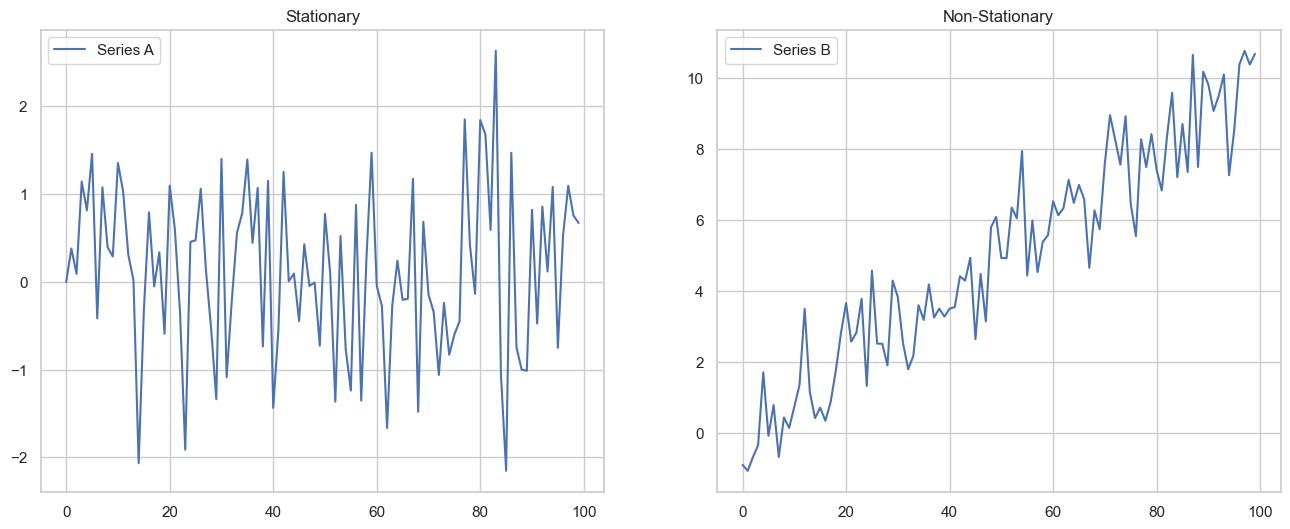

In [3]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

T = 100

# Generating stationary time series
params = (0, 1)
A = pd.Series(index=range(T))
A.name = 'A'
for t in range(T):
    A[t] = generate_data(params)

# Generating non-stationary time series
B = pd.Series(index=range(T))
B.name = 'B'
for t in range(T):
    params = (t * 0.1, 1)
    B[t] = generate_data(params)

# Plotting the time series
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')
plt.show()


We can visually observe that the first plot (Series A) is stationary, while the second plot (Series B) is non-stationary.

**Augmented Dickey Fuller (ADF) Test for Stationarity**

To test for stationarity, we will use the Augmented Dickey Fuller (ADF) test. The ADF test is a unit root test that determines whether a time series has a unit root (indicating non-stationarity). Let's implement a function to perform the ADF test and test our generated time series:

In [4]:
def stationarity_test(X, cutoff=0.01):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print(f'p-value = {pvalue:.15f}. The series {X.name} is likely stationary.')
    else:
        print(f'p-value = {pvalue:.15f}. The series {X.name} is likely non-stationary.')

# Testing for stationarity
stationarity_test(A)
stationarity_test(B)


p-value = 0.000000000000000. The series A is likely stationary.
p-value = 0.877558890241372. The series B is likely non-stationary.


The output will indicate whether each series is likely to be stationary or non-stationary.

**Finding Cointegrated Pairs of Securities**

Next, we will find cointegrated pairs of securities by analyzing the correlation between their prices. We'll use historical price data for companies in Dow Jones Index basket from yahoo finance to check cointegration.

In [7]:
import statsmodels.tsa.stattools as ts

# List of tech companies
tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

# Download historical price data
start_date = '2013-01-01'
end_date = '2018-01-01'
df = yf.download(tickers, start=start_date, end=end_date)['Close']

# Finding cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = ts.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(df)
print(pairs)


[*********************100%***********************]  11 of 11 completed
[('AAPL', 'SPY'), ('ADBE', 'EBAY'), ('ADBE', 'MSFT'), ('HPQ', 'ORCL')]


**Creating and Backtesting the Pairs Trading Strategy**

Now that we have identified cointegrated pairs, let's implement and backtest the pairs trading strategy using the selected pairs:

In [26]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def trade(S1, S2, window1, window2, transaction_cost=0.002, tax_rate=0.03, buy_threshold=-0.4, sell_threshold=0.4):
 # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std

    # Simulate trading
    money = 0
    countS1 = 0
    countS2 = 0
    buy_signals = []
    sell_signals = []

    for i in range(len(ratios) - 1):  # Note the change here, loop until len(ratios) - 1
        if zscore[i] < -1.2:  # Buy S1 and sell S2
            buy_signals.append(i + 1)
            transaction_cost1 = S1[i + 1] * transaction_cost
            transaction_cost2 = S2[i + 1] * transaction_cost
            money += (S1[i + 1] - transaction_cost1) - (S2[i + 1] + transaction_cost2) * ratios[i + 1]
            countS1 -= 1
            countS2 += ratios[i + 1]
        elif zscore[i] > 1.3:  # Sell S1 and buy S2
            sell_signals.append(i + 1)
            transaction_cost1 = S1[i + 1] * transaction_cost
            transaction_cost2 = S2[i + 1] * transaction_cost
            money -= (S1[i + 1] + transaction_cost1) - (S2[i + 1] - transaction_cost2) * ratios[i + 1]
            countS1 += 1
            countS2 -= ratios[i + 1]
        elif abs(zscore[i]) < 1:  # Clear positions
            money += (S1[i + 1] * countS1) + (S2[i + 1] * countS2) - (S1[i + 1] * countS1 * tax_rate) - (S2[i + 1] * countS2 * tax_rate)
            countS1 = 0
            countS2 = 0

    return money, buy_signals, sell_signals



# Define the range of values for the threshold and window parameters
buy_thresholds = [-0.4, -0.5, -0.6,-0.7,-0.8,-0.9,-1.0]
sell_thresholds = [0.4, 0.5, 0.6,0.7,0.8,0.9,1.0]
window1_intervals = [5, 10, 15,20,25,30,35,40,45,50,55,60,65,70,75,80]
window2_intervals = [20,25,30,35,40,45,50,55,60,65,70,75,80]

# Initialize variables to keep track of best parameters and profit
best_params = None
best_profit = float('-inf')

# Iteratively test different combinations of parameters
for buy_threshold in buy_thresholds:
    for sell_threshold in sell_thresholds:
        for window1_interval in window1_intervals:
            for window2_interval in window2_intervals:
                # Backtest the pairs trading strategy for the current parameters
                profits = []
                for pair in pairs:
                    S1 = df[pair[0]]
                    S2 = df[pair[1]]
                    profit, _, _ = trade(S1, S2, window1=window1_interval, window2=window2_interval,
                                         transaction_cost=0.002, tax_rate=0.3, buy_threshold=buy_threshold, 
                                         sell_threshold=sell_threshold)
                    profits.append(profit)

                # Calculate the overall strategy performance
                total_profit = np.sum(profits)

                # Check if the current parameters result in higher profit
                if total_profit > best_profit:
                    best_params = (buy_threshold, sell_threshold, window1_interval, window2_interval)
                    best_profit = total_profit

# Extract the best parameters
best_buy_threshold, best_sell_threshold, best_window1, best_window2 = best_params

print(f"Best parameters: Buy threshold={best_buy_threshold}, Sell threshold={best_sell_threshold}, "
      f"Window1={best_window1}, Window2={best_window2}")
print(f"Total profit for the pairs trading strategy with the best parameters: ${best_profit:.2f}")

Best parameters: Buy threshold=-0.4, Sell threshold=0.4, Window1=70, Window2=20
Total profit for the pairs trading strategy with the best parameters: $1506.69


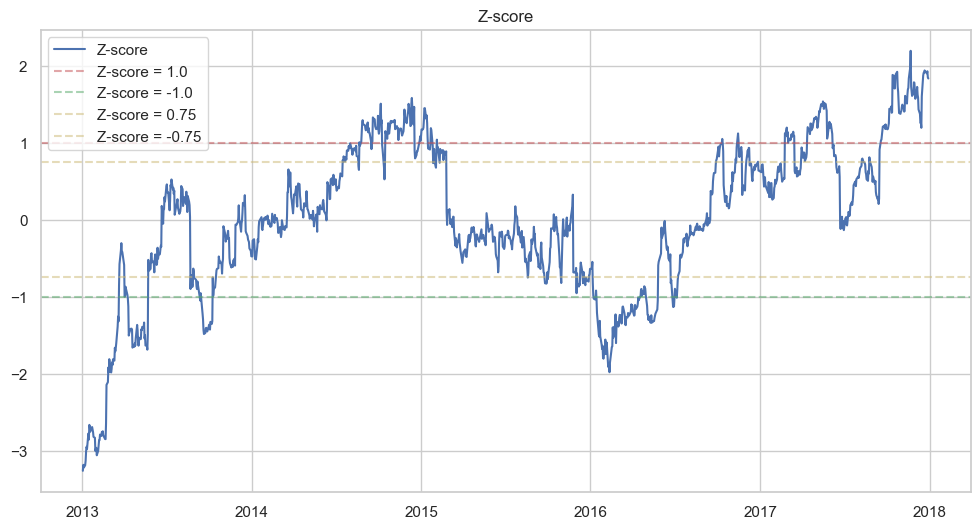

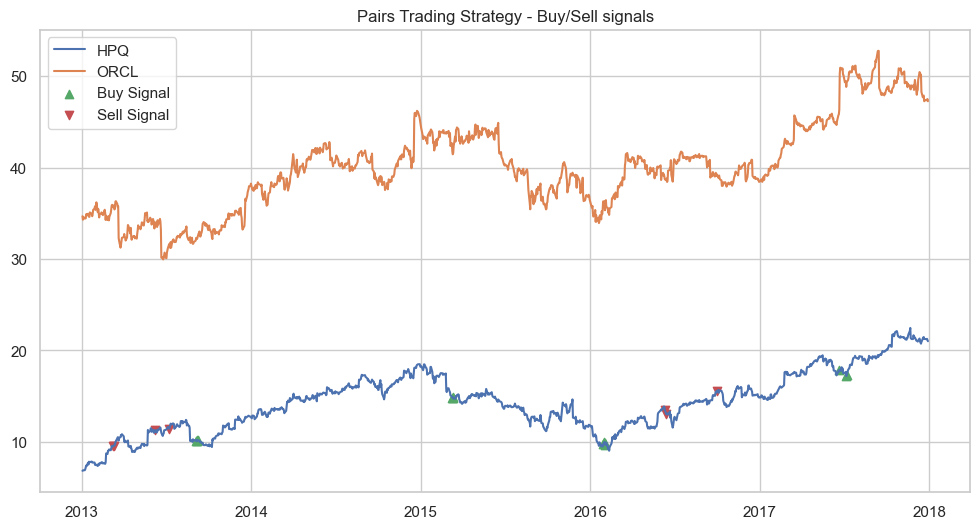

In [27]:
# Assuming you have executed the previous code up to defining the 'all_buy_signals' and 'all_sell_signals' lists.

# Calculate the z-score for the first pair in 'pairs' list
pair_index = 3
pair = pairs[pair_index]
S1 = df[pair[0]]
S2 = df[pair[1]]
ratios = S1 / S2
zscore = (ratios - ratios.mean()) / ratios.std()

# Plotting the z-score and moving average trading signals
plt.figure(figsize=(12, 6))
plt.plot(zscore.index, zscore.values, label='Z-score')
plt.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Z-score = 1.0')
plt.axhline(-1.0, color='g', linestyle='--', alpha=0.5, label='Z-score = -1.0')
plt.axhline(0.75, color='y', linestyle='--', alpha=0.5, label='Z-score = 0.75')
plt.axhline(-0.75, color='y', linestyle='--', alpha=0.5, label='Z-score = -0.75')
plt.title("Z-score")
plt.legend(loc='upper left')

# Plotting the pairs trading strategy with buy and sell signals for the first pair in 'pairs' list
plt.figure(figsize=(12, 6))
plt.plot(S1.index, S1.values, label=pair[0])
plt.plot(S2.index, S2.values, label=pair[1])
plt.scatter(S1.index[all_buy_signals[pair_index]], S1.values[all_buy_signals[pair_index]], marker='^', color='g', label='Buy Signal')
plt.scatter(S1.index[all_sell_signals[pair_index]], S1.values[all_sell_signals[pair_index]], marker='v', color='r', label='Sell Signal')
plt.legend(loc='upper left')

plt.title("Pairs Trading Strategy - Buy/Sell signals")
plt.legend(loc='upper left')
plt.show()



**Conclusion**

In this notebook, we implemented a pairs trading strategy using Python. We started by understanding the concepts of stationarity, integration, and cointegration. We then tested for stationarity using the Augmented Dickey Fuller (ADF) test and identified cointegrated pairs of securities. Finally, we created and backtested the pairs trading strategy, calculating the overall profit.

Please note that this is a basic example for educational purposes, and in real-world applications, there are many other factors to consider, such as transaction costs, risk management, and portfolio optimization.

Keep in mind that financial trading involves risk, and past performance is not indicative of future results. Always perform due diligence and consider consulting with a financial professional before implementing any trading strategies.